In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Verifique se CUDA está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# Preprocessamento do MNIST
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Alguns hiperparâmetros
input_dim = 784  # Imagens 28x28 serão representadas por um array de 784 entradas
label_dim = 10  # Número de labels possíveis (de 0 a 9)

hidden_dim_encoder = 784
hidden_dim_decoder = 64   # Diminuímos a dimensão dos dados no decoder
# caso queiramos que o encoder "capture" mais features, seria interessante aumentar seu hidden_dim
# o mesmo vale para o decoder, onde poderiamos buscar "gerar" mais complexidade ao modelo
latent_dim = 10  # dimensão de representação latente

In [3]:
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim_encoder, hidden_dim_decoder, latent_dim):
        super(CVAE, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(16 * 14 * 14 + label_dim, hidden_dim_encoder)
        self.fc_mean = nn.Linear(hidden_dim_encoder, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim_encoder, latent_dim)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim + label_dim, hidden_dim_decoder)
        self.fc3 = nn.Linear(hidden_dim_decoder, input_dim)

    def encode(self, x, y):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        input = torch.cat((x, y), dim=1) # aqui que fazemos a parte "condicional" do VAE
        hidden = F.relu(self.fc1(input))
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def decode(self, z, y):
        input = torch.cat((z, y), dim=1)  # aqui que fazemos a parte "condicional" do VAE
        hidden = F.relu(self.fc2(input)) 
        reconstructed = torch.sigmoid(self.fc3(hidden))
        return reconstructed

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        z = self.reparametrize(mean, logvar)
        reconstructed = self.decode(z, y)
        return reconstructed, mean, logvar

def loss_function(reconstructed, x, mean, logvar):
    # loss (binary cross-entropy)
    reconstruction_loss = F.binary_cross_entropy(reconstructed.view(-1, input_dim), x.view(-1, input_dim), reduction='sum')
    
    # loss (divergencia KL)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    total_loss = reconstruction_loss + kl_loss
    return total_loss

model = CVAE(input_dim, label_dim, hidden_dim_encoder, hidden_dim_decoder, latent_dim)
model = model.to(device)

# podemos mudar o otimizador também / adicionamos weight_decay para implementar regularização L2
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [4]:
def train(model, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = F.one_hot(labels, num_classes=10).type(torch.float).to(device)
            optimizer.zero_grad()
            
            reconstructed, mean, logvar = model(data, labels)
            
            loss = loss_function(reconstructed, data.view(-1, input_dim), mean, logvar)
            
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            # Print training information
            if batch_idx % 100 == 0:
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))
        
        print('Epoch [{}/{}], Average Loss: {:.4f}'
              .format(epoch+1, num_epochs, train_loss/len(train_loader)))

num_epochs = 10
train(model, optimizer, num_epochs)

Epoch [1/10], Batch [1/469], Loss: 69810.7344
Epoch [1/10], Batch [101/469], Loss: 41911.5625
Epoch [1/10], Batch [201/469], Loss: 37519.7070
Epoch [1/10], Batch [301/469], Loss: 36034.8984
Epoch [1/10], Batch [401/469], Loss: 35629.7305
Epoch [1/10], Average Loss: 39700.2956
Epoch [2/10], Batch [1/469], Loss: 35685.7773
Epoch [2/10], Batch [101/469], Loss: 34782.5312
Epoch [2/10], Batch [201/469], Loss: 33575.6719
Epoch [2/10], Batch [301/469], Loss: 32866.8477
Epoch [2/10], Batch [401/469], Loss: 32898.2539
Epoch [2/10], Average Loss: 33917.1943
Epoch [3/10], Batch [1/469], Loss: 32738.2656
Epoch [3/10], Batch [101/469], Loss: 33691.6875
Epoch [3/10], Batch [201/469], Loss: 33509.1719
Epoch [3/10], Batch [301/469], Loss: 32639.7559
Epoch [3/10], Batch [401/469], Loss: 32629.4258
Epoch [3/10], Average Loss: 33176.7344
Epoch [4/10], Batch [1/469], Loss: 32755.0801
Epoch [4/10], Batch [101/469], Loss: 34186.7266
Epoch [4/10], Batch [201/469], Loss: 33507.1172
Epoch [4/10], Batch [301/46

Imagens de: Sneaker


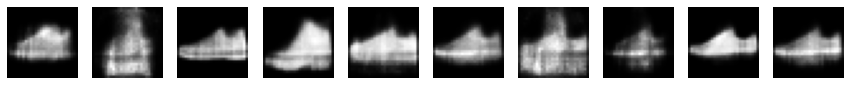

In [7]:

import matplotlib.pyplot as plt

# geraçao de novas amostras
def generate_samples(model, num_samples, label):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        y = torch.zeros(num_samples, label_dim).to(device)
        y[:, label] = 1
        generated_samples = model.decode(z, y)

    clothing_map = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot'
    }
    
    print(f'Imagens de: {clothing_map[label]}')
    return generated_samples

num_samples = 10
generated_samples = generate_samples(model, num_samples, 7)

generated_samples = generated_samples.view(-1, 28, 28)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples[i].cpu().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()